Importing Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

Loading Dataset

In [2]:
df = pd.read_csv('features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [3]:
df.shape

(9990, 60)

In [4]:
df.label.value_counts().reset_index()

label  count
0      blues   1000
1       jazz   1000
2      metal   1000
3        pop   1000
4     reggae   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

Exploratory Data Analysis

In [99]:
audio_fp = './Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp, mono = False)
audio_data, _ = librosa.effects.trim(audio_data)

In [100]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y,audio_data, sr=sr)
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

TypeError: waveshow() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

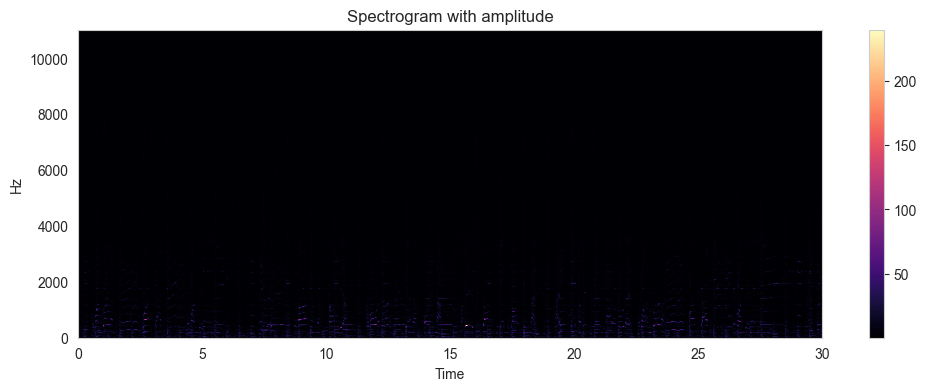

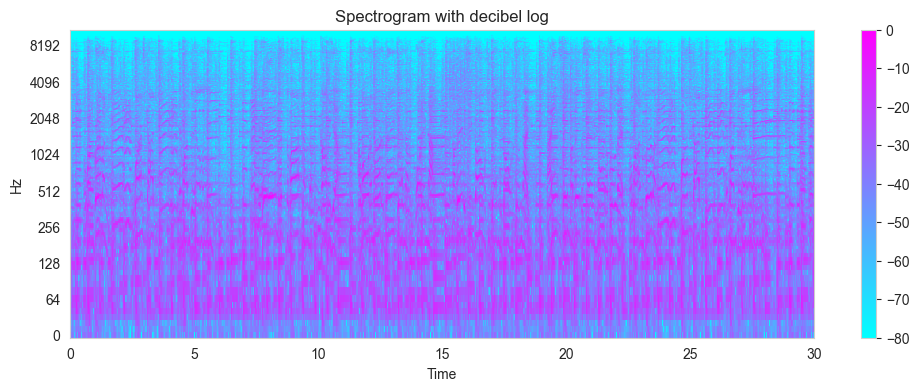

In [9]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

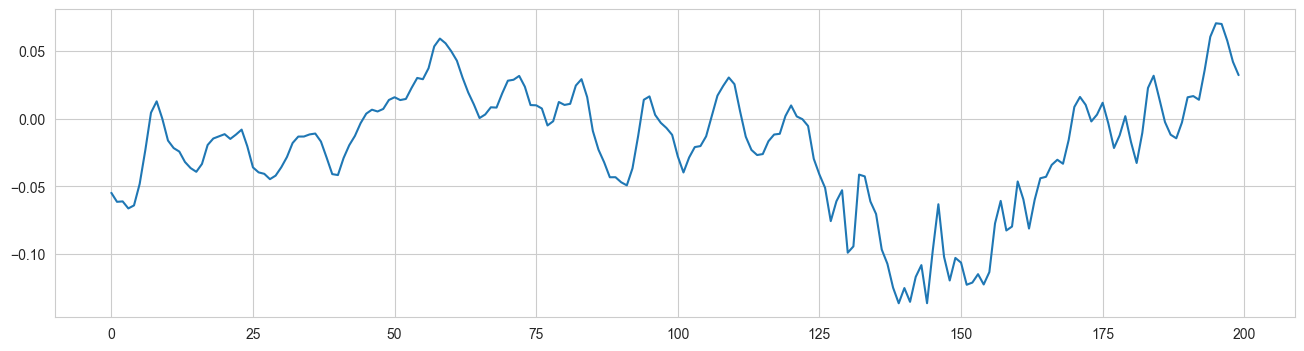

In [10]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

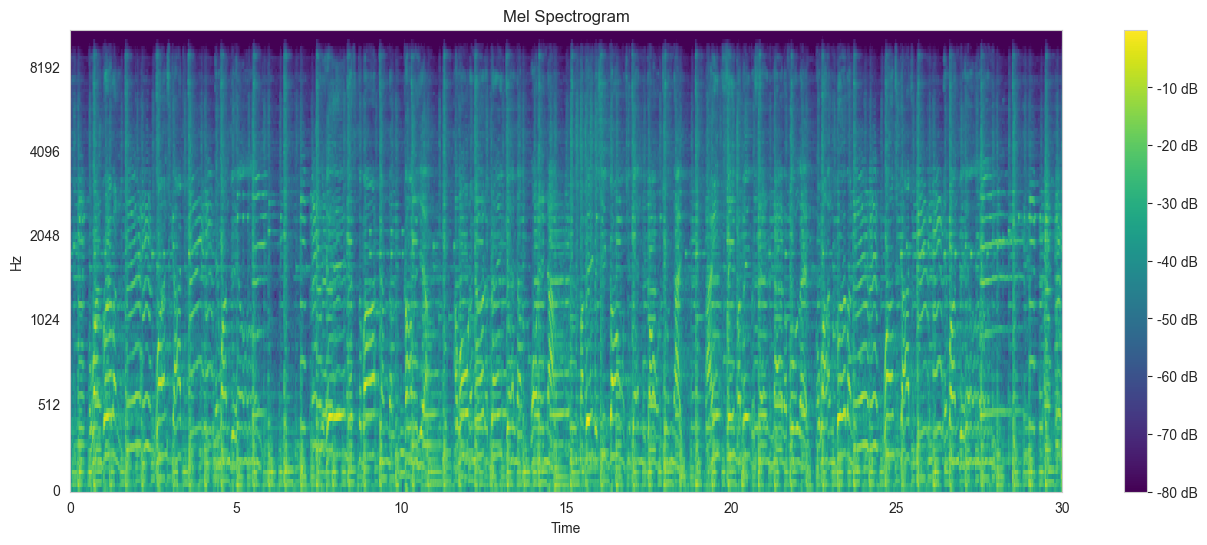

In [12]:
# Calculate the mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)

# Convert to decibels
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the mel spectrogram
plt.figure(figsize=(16, 6))
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

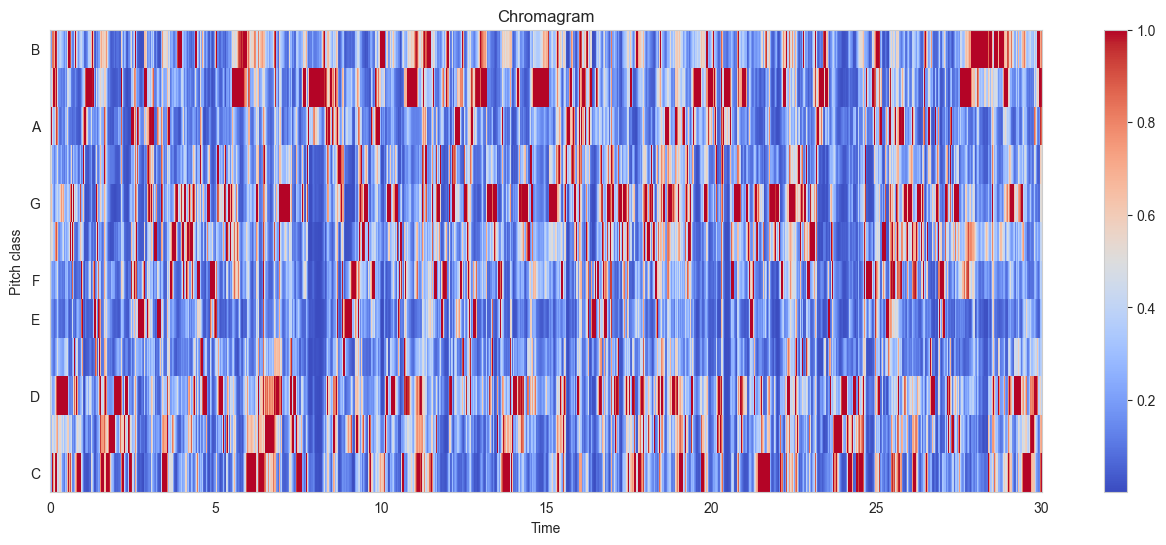

In [16]:
# Calculate the chromagram
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)

# Plot the chromagram
plt.figure(figsize=(16, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram')
plt.show()

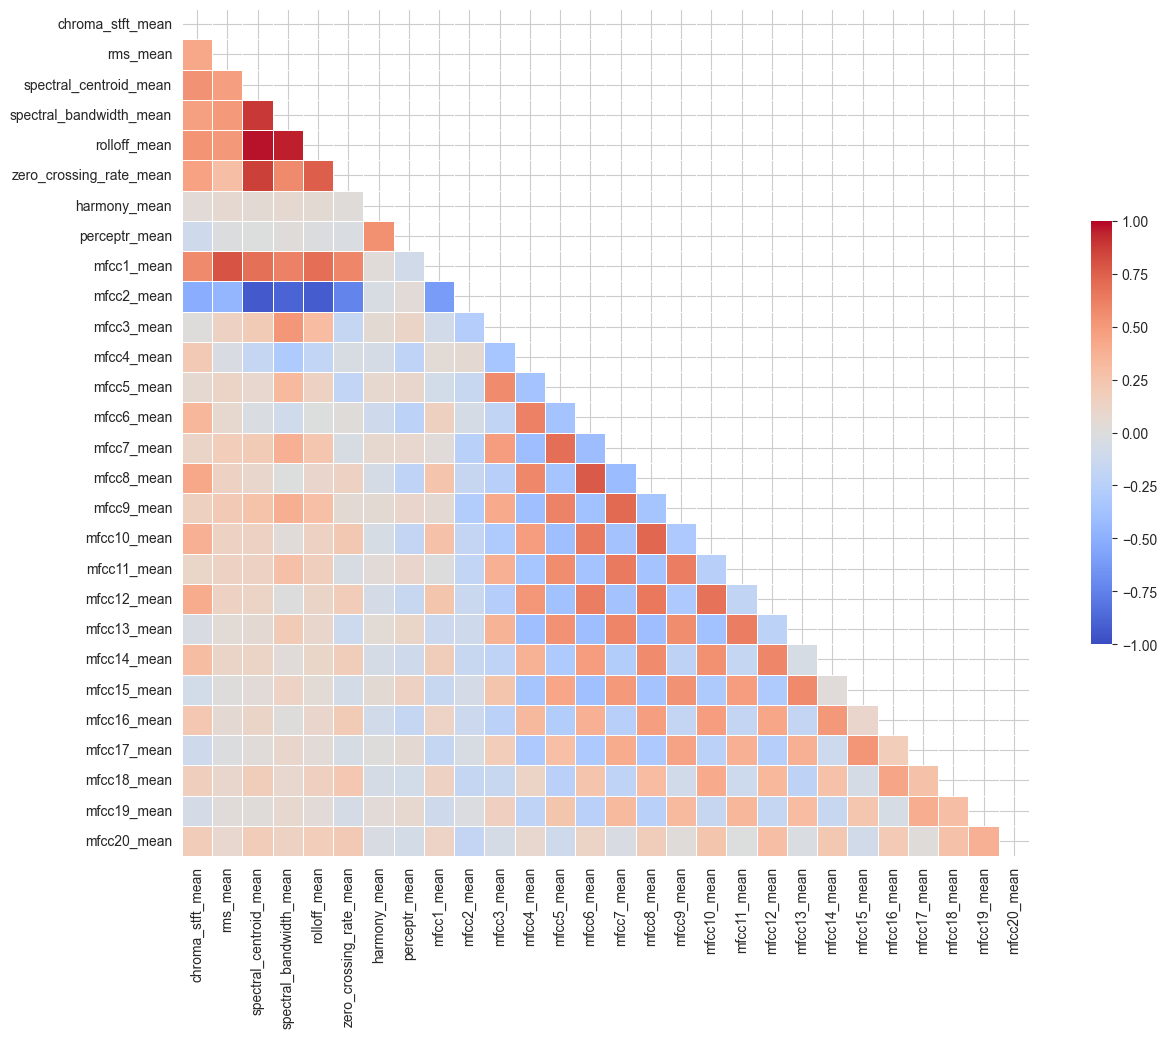

In [18]:
# Calculate correlation matrix
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

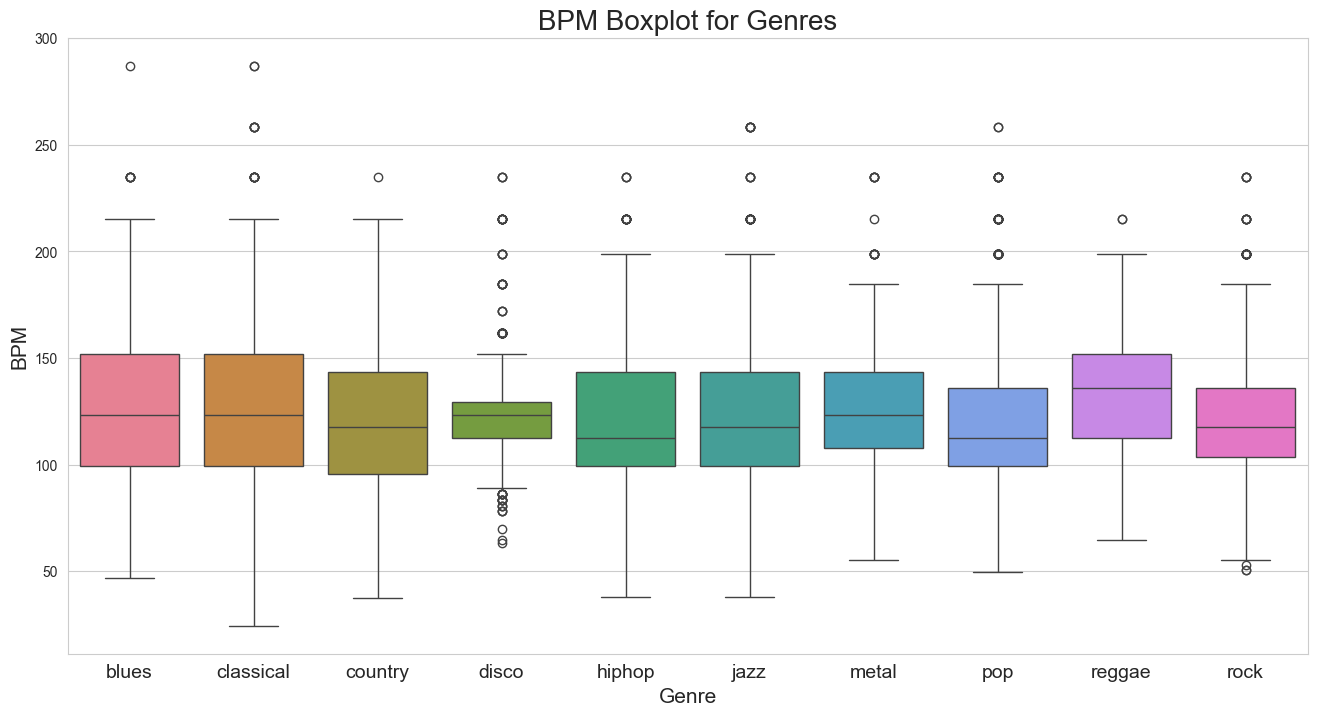

In [20]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

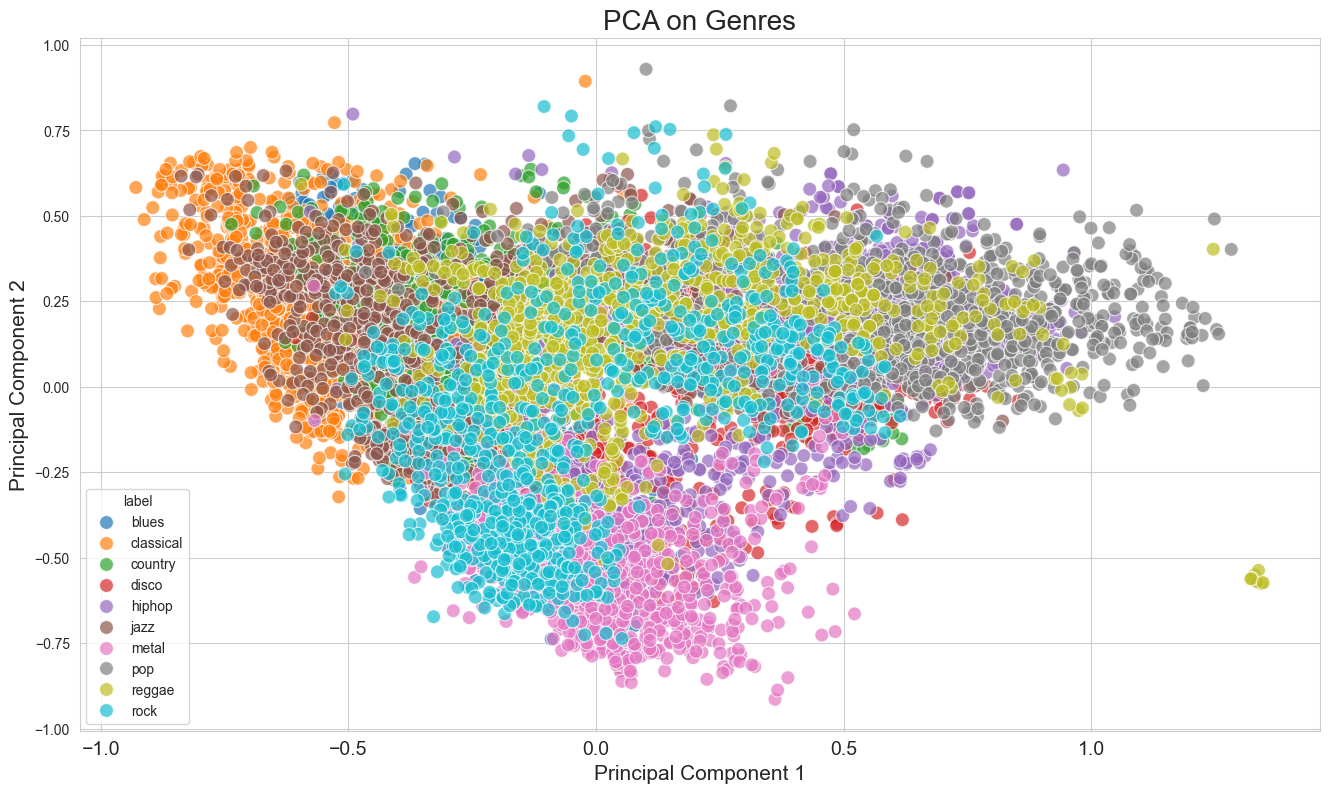

In [21]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

Data Preparation

In [22]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [23]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Split into Train Dev Test Data

In [24]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [25]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [26]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [27]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


In [28]:
# Scale the Features
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

Feature Engineering

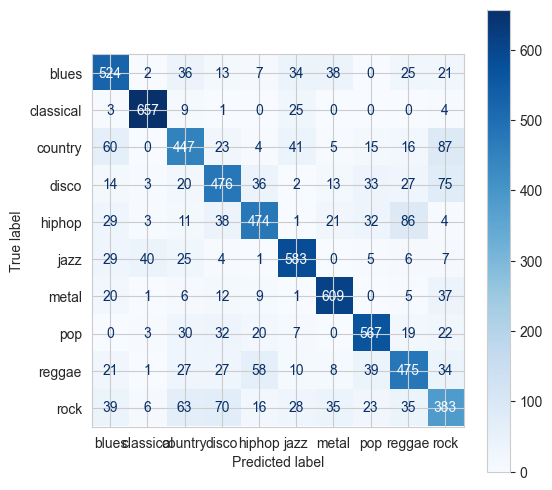

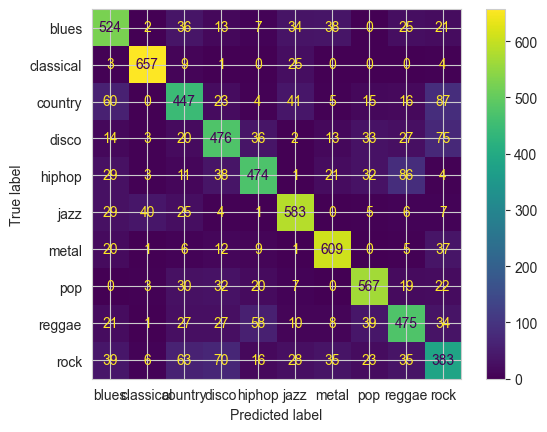

              precision    recall  f1-score   support

       blues      0.709     0.749     0.728       700
   classical      0.918     0.940     0.929       699
     country      0.663     0.640     0.652       698
       disco      0.684     0.681     0.682       699
      hiphop      0.758     0.678     0.716       699
        jazz      0.796     0.833     0.814       700
       metal      0.835     0.870     0.852       700
         pop      0.794     0.810     0.802       700
      reggae      0.684     0.679     0.681       700
        rock      0.568     0.549     0.558       698

    accuracy                          0.743      6993
   macro avg      0.741     0.743     0.742      6993
weighted avg      0.741     0.743     0.742      6993



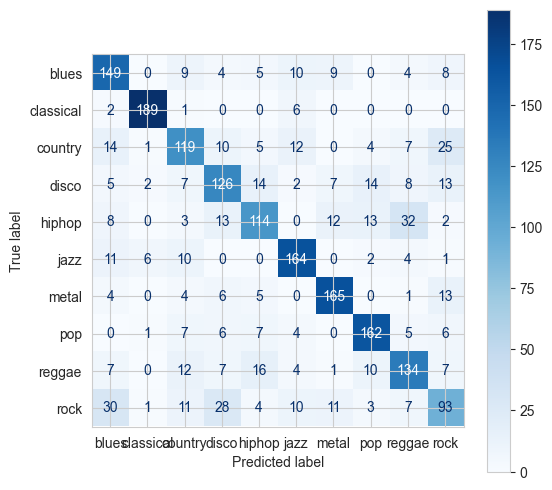

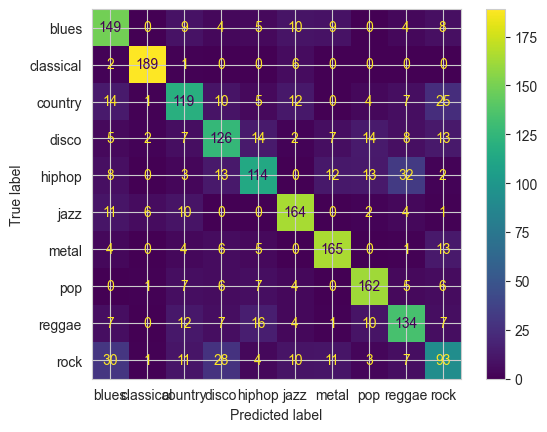

              precision    recall  f1-score   support

       blues      0.648     0.753     0.696       198
   classical      0.945     0.955     0.950       198
     country      0.650     0.604     0.626       197
       disco      0.630     0.636     0.633       198
      hiphop      0.671     0.579     0.621       197
        jazz      0.774     0.828     0.800       198
       metal      0.805     0.833     0.819       198
         pop      0.779     0.818     0.798       198
      reggae      0.663     0.677     0.670       198
        rock      0.554     0.470     0.508       198

    accuracy                          0.715      1978
   macro avg      0.712     0.715     0.712      1978
weighted avg      0.712     0.715     0.712      1978



In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

def predictProba(clf, X, y_true, dev=False):
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev

    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay.from_estimator(clf, X, y_true)
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax)
    plt.show()

    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")


# Sample Logistic Regression Model
# Building model with all features
lr = LogisticRegression(random_state=seed)
lr.fit(X_train, y_train)

# Call the function for training data
predictProba(lr, X_train, y_train)

# Call the function for development data
predictProba(lr, X_dev, y_dev, dev=True)


In [41]:
# Permutation Importance Feature Selection
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


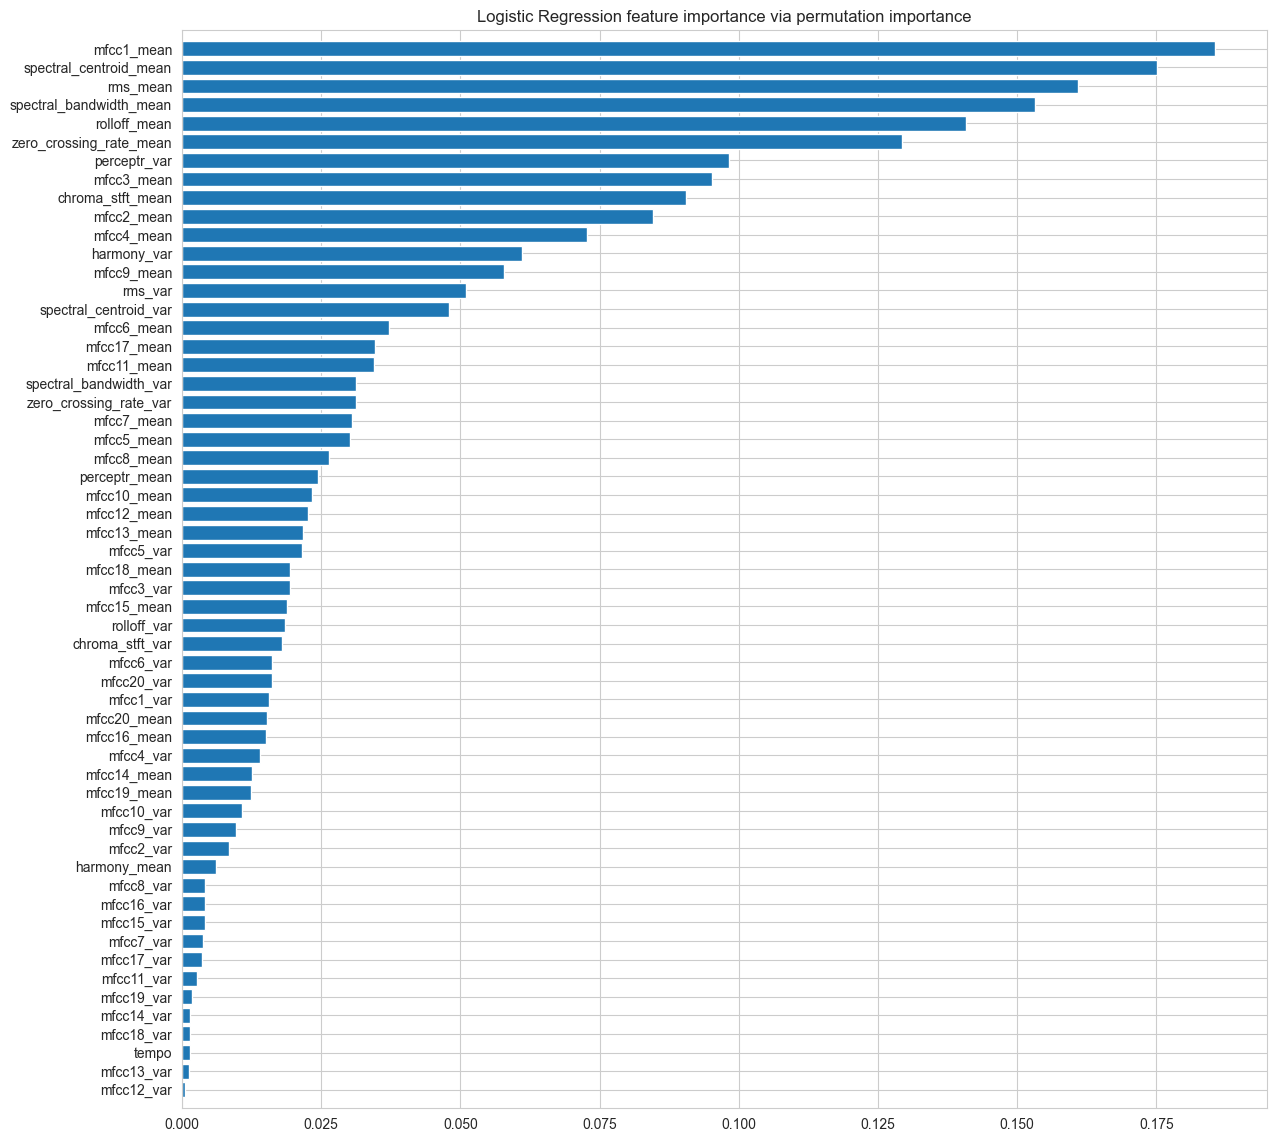

In [42]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()


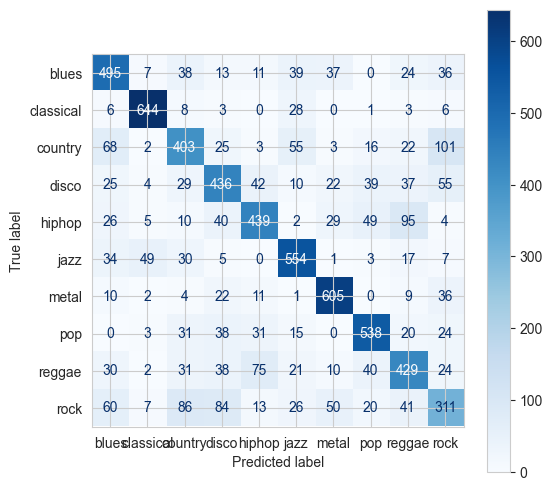

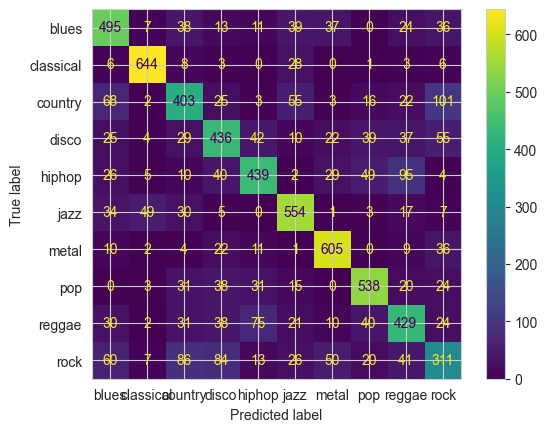

              precision    recall  f1-score   support

       blues      0.656     0.707     0.681       700
   classical      0.888     0.921     0.904       699
     country      0.601     0.577     0.589       698
       disco      0.619     0.624     0.622       699
      hiphop      0.702     0.628     0.663       699
        jazz      0.738     0.791     0.764       700
       metal      0.799     0.864     0.830       700
         pop      0.762     0.769     0.765       700
      reggae      0.615     0.613     0.614       700
        rock      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



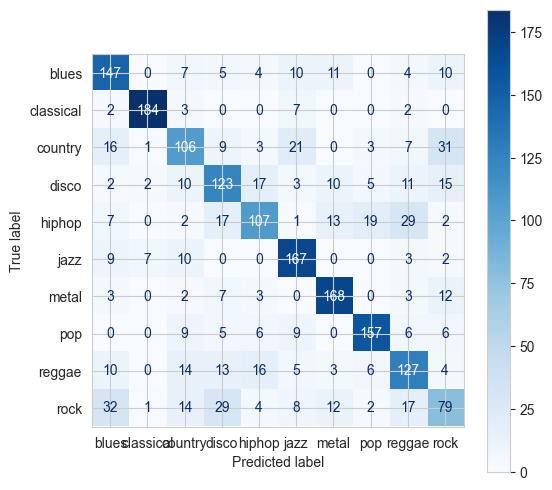

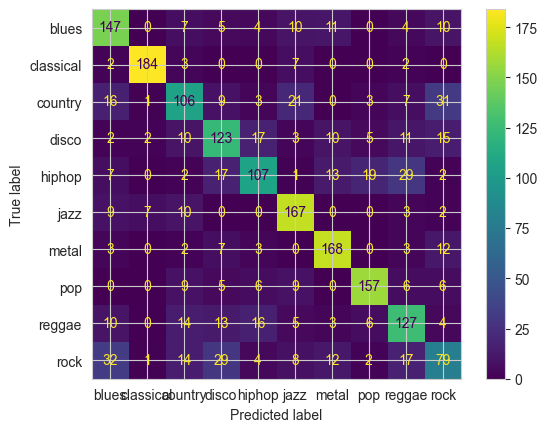

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [44]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm, y_train)
predictProba(lr, X_train_perm, y_dev, dev=True)

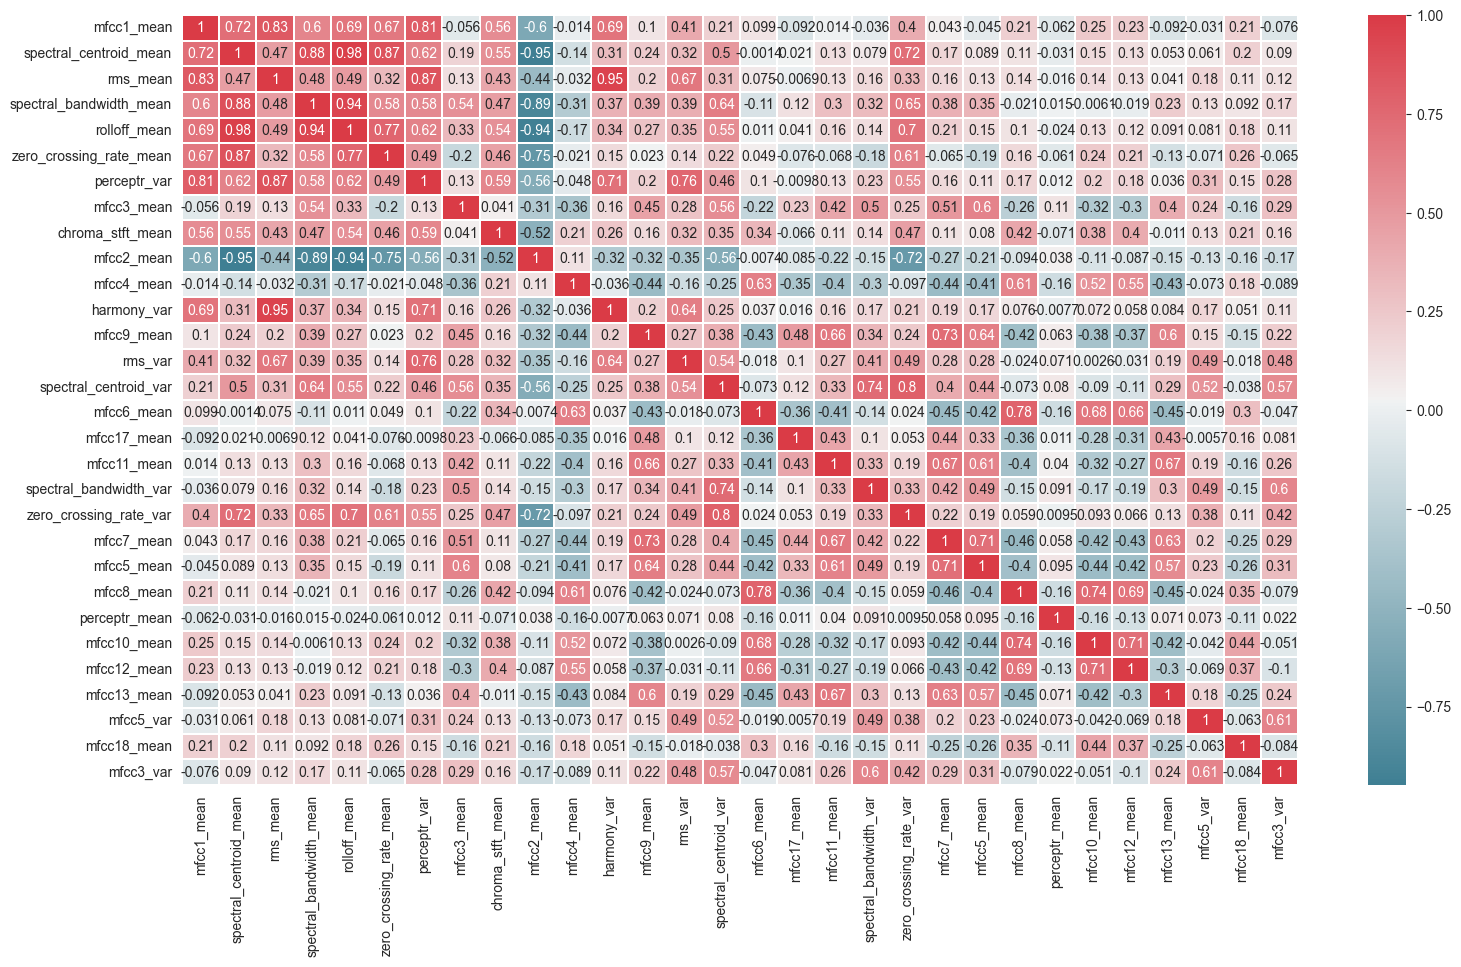

In [45]:
# Correlation Heatmap

# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

Model Building

Logistic Regression

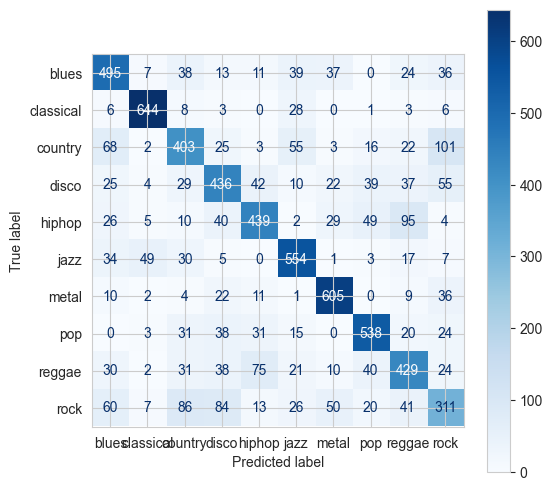

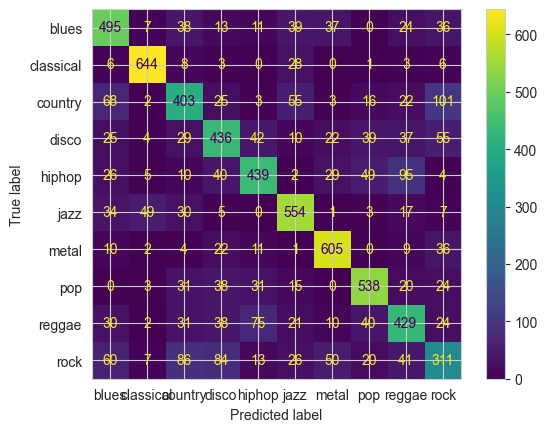

              precision    recall  f1-score   support

       blues      0.656     0.707     0.681       700
   classical      0.888     0.921     0.904       699
     country      0.601     0.577     0.589       698
       disco      0.619     0.624     0.622       699
      hiphop      0.702     0.628     0.663       699
        jazz      0.738     0.791     0.764       700
       metal      0.799     0.864     0.830       700
         pop      0.762     0.769     0.765       700
      reggae      0.615     0.613     0.614       700
        rock      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



In [47]:
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe, y_train)

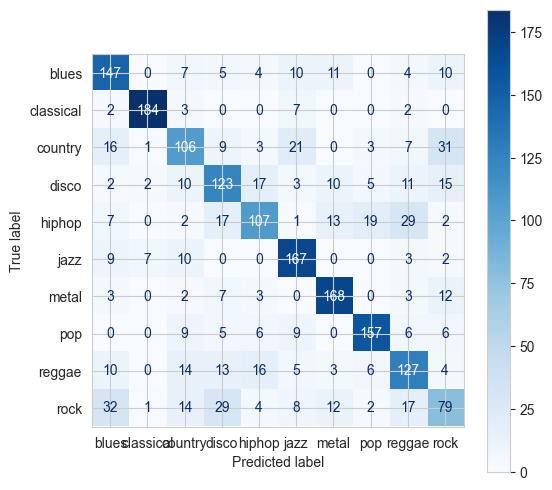

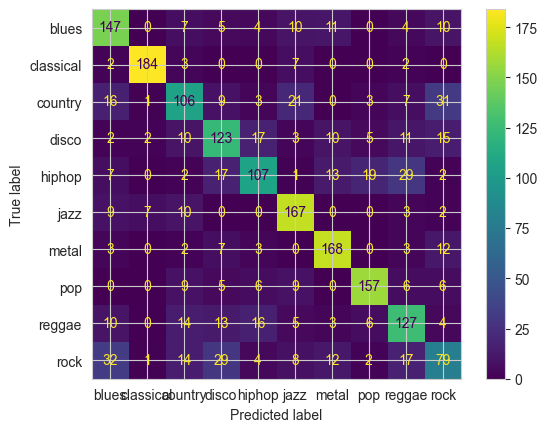

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [48]:
predictProba(lr, X_train_rfe,y_train, True)

Random Forest

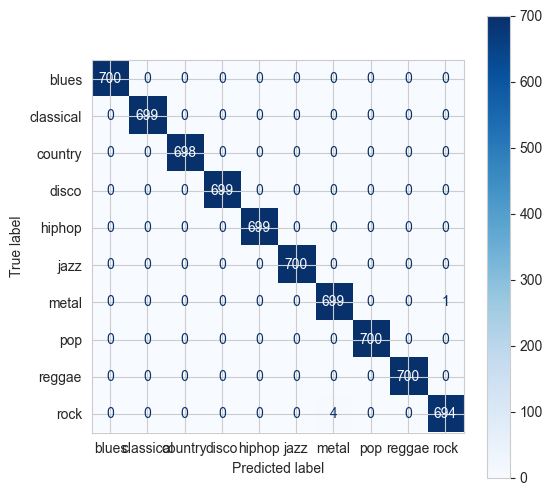

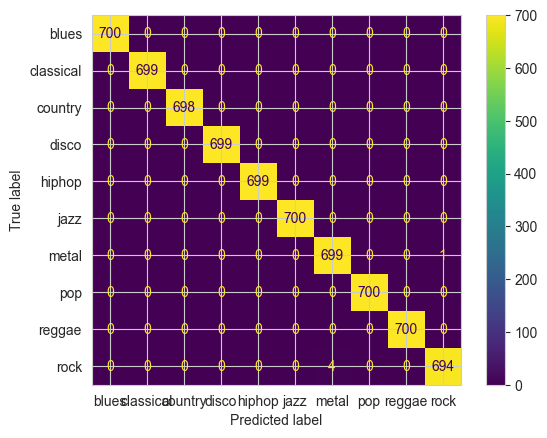

              precision    recall  f1-score   support

       blues      1.000     1.000     1.000       700
   classical      1.000     1.000     1.000       699
     country      1.000     1.000     1.000       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      1.000     1.000     1.000       700
       metal      0.994     0.999     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      1.000     1.000     1.000       700
        rock      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [50]:
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe, y_train)

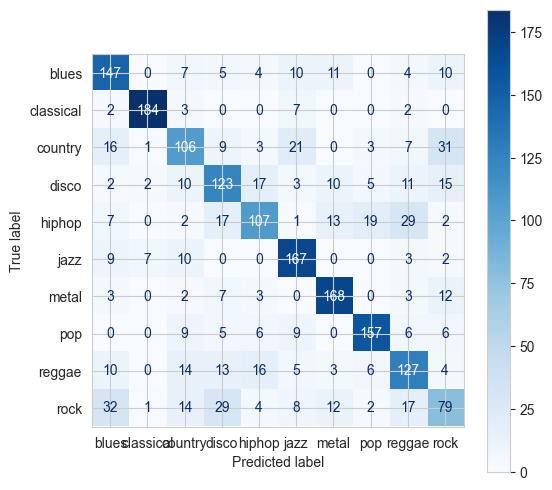

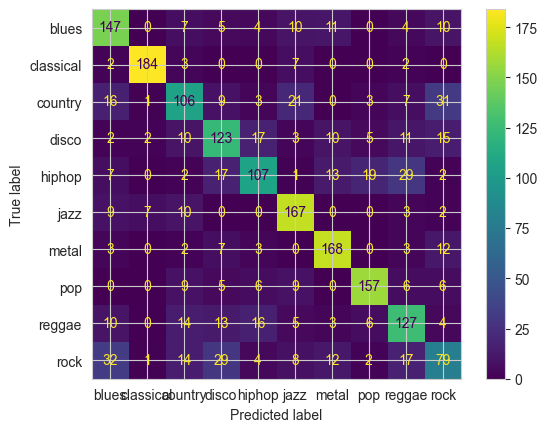

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [51]:
predictProba(lr, X_train_rfe,y_train, True)

AdaBoost

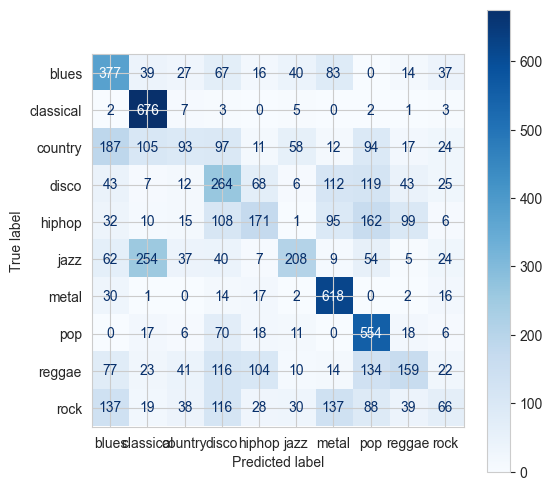

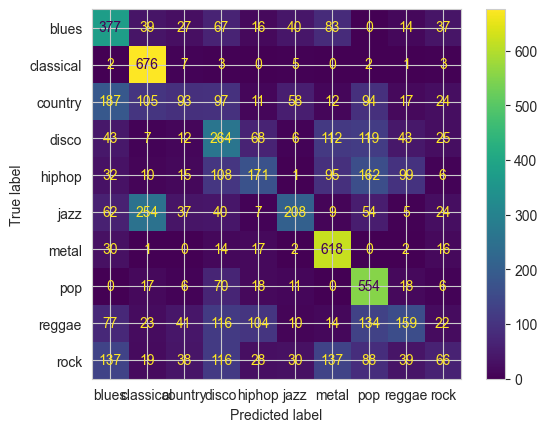

              precision    recall  f1-score   support

       blues      0.398     0.539     0.458       700
   classical      0.587     0.967     0.731       699
     country      0.337     0.133     0.191       698
       disco      0.295     0.378     0.331       699
      hiphop      0.389     0.245     0.300       699
        jazz      0.561     0.297     0.388       700
       metal      0.572     0.883     0.694       700
         pop      0.459     0.791     0.581       700
      reggae      0.401     0.227     0.290       700
        rock      0.288     0.095     0.142       698

    accuracy                          0.456      6993
   macro avg      0.429     0.455     0.411      6993
weighted avg      0.429     0.456     0.411      6993



In [53]:
abc = ske.AdaBoostClassifier(n_estimators=100, random_state=seed)
abc.fit(X_train_rfe, y_train)
predictProba(abc, X_train_rfe, y_train)

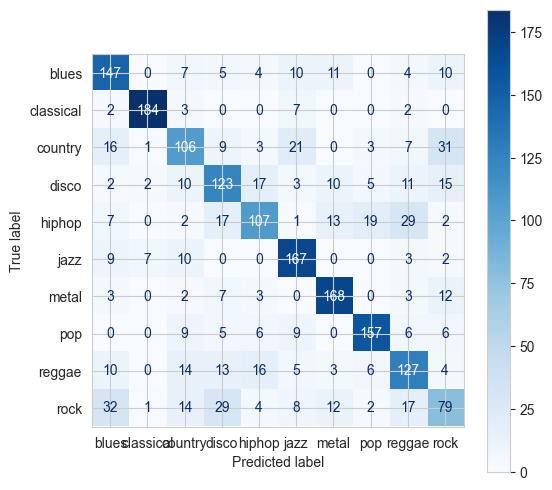

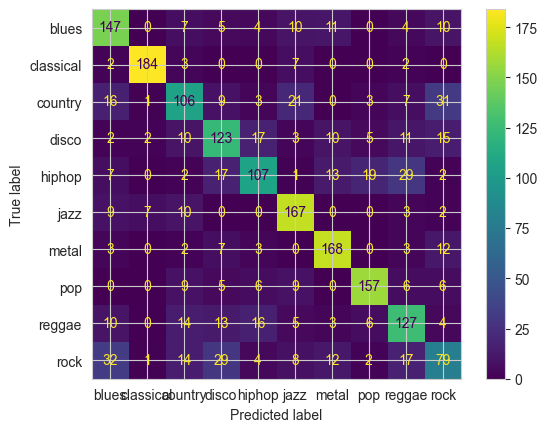

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [54]:
predictProba(lr, X_train_rfe,y_train, True)

GBM

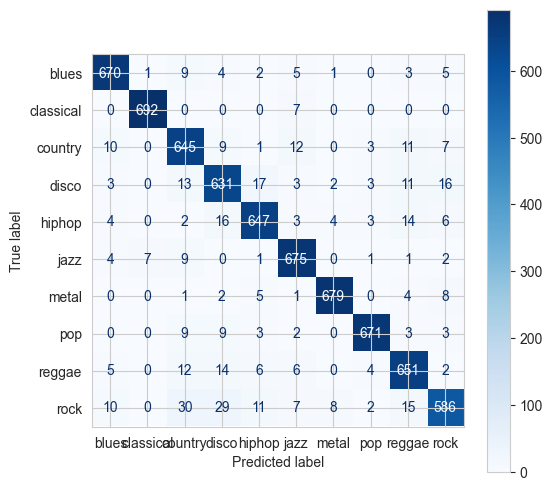

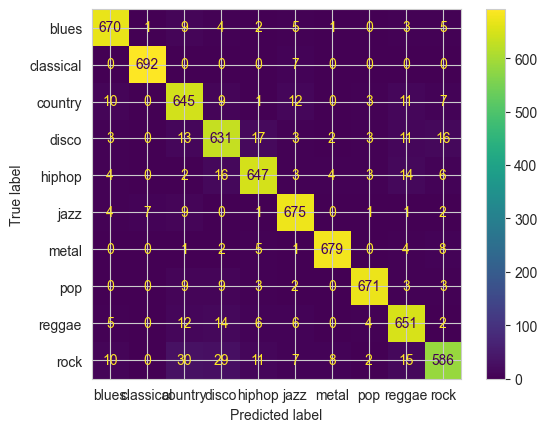

              precision    recall  f1-score   support

       blues      0.949     0.957     0.953       700
   classical      0.989     0.990     0.989       699
     country      0.884     0.924     0.903       698
       disco      0.884     0.903     0.893       699
      hiphop      0.934     0.926     0.930       699
        jazz      0.936     0.964     0.950       700
       metal      0.978     0.970     0.974       700
         pop      0.977     0.959     0.968       700
      reggae      0.913     0.930     0.921       700
        rock      0.923     0.840     0.879       698

    accuracy                          0.936      6993
   macro avg      0.937     0.936     0.936      6993
weighted avg      0.937     0.936     0.936      6993



In [55]:
gbc = ske.GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbc.fit(X_train_rfe, y_train)
predictProba(gbc, X_train_rfe, y_train)

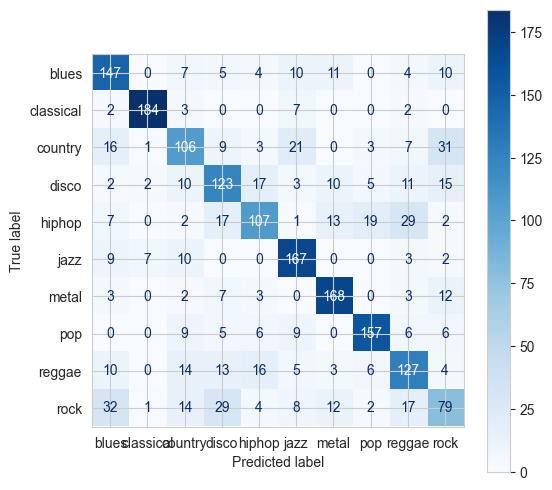

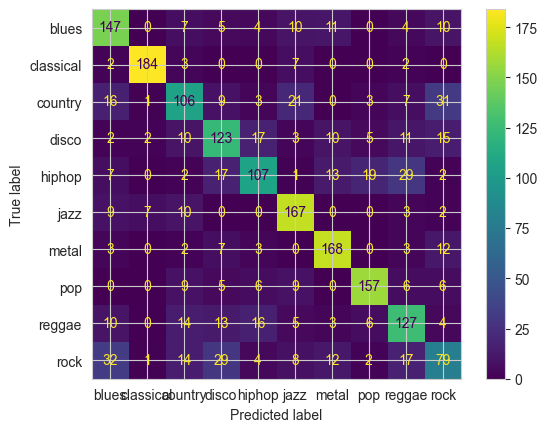

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [56]:
predictProba(lr, X_train_rfe,y_train, True)

CatBoost

In [67]:
!pip install catboost
import catboost as cb
print(cb.__version__)

   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.0 MB 1.1 MB/s eta 0:01:29
   ---------------------------------------- 0.1/101.0 MB 1.1 MB/s eta 0:01:29
   ---------------------------------------- 0.1/101.0 MB 595.3 kB/s eta 0:02:50
   ---------------------------------------- 0.1/101.0 MB 595.3 kB/s eta 0:02:50
   ---------------------------------------- 0.1/101.0 MB 500.5 kB/s eta 0:03:22
   ---------------------------------------- 0.1/101.0 MB 500.5 kB/s eta 0:03:22
   ---------------------------------------- 0.2/101.0 MB 436.9 kB/s eta 0:03:51
   ---------------------------------------- 0.2/101.0 MB 436.8 kB/s eta 0:03:51
   ---------------------------------------- 0.2/101.0 MB 436.8 kB/s eta 0:03:51
   ---------------------------------------- 0.2/101.0 MB 430.1 kB/s eta 0:03:55
   ---------------------------------------- 0.3/101.0 MB 459.8

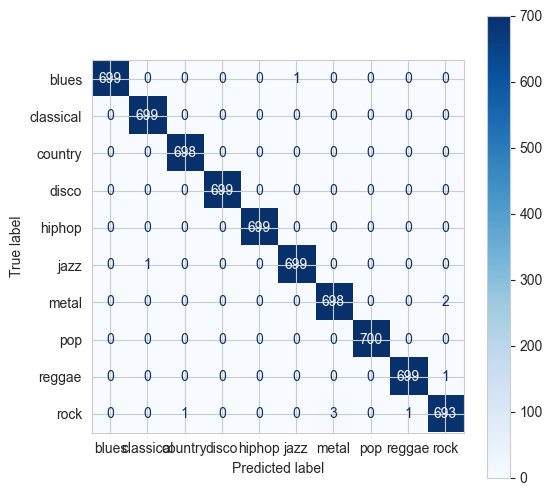

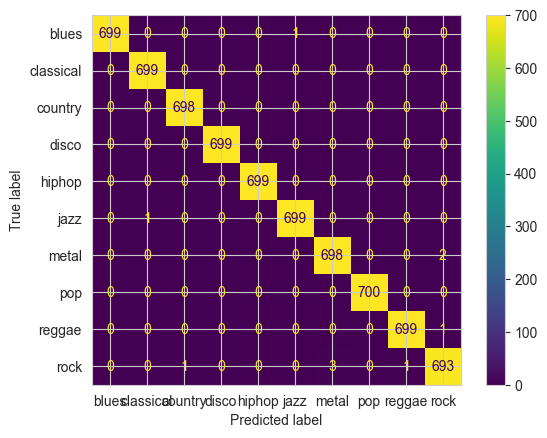

              precision    recall  f1-score   support

       blues      1.000     0.999     0.999       700
   classical      0.999     1.000     0.999       699
     country      0.999     1.000     0.999       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      0.999     0.999     0.999       700
       metal      0.996     0.997     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      0.999     0.999     0.999       700
        rock      0.996     0.993     0.994       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [69]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe, y_train)

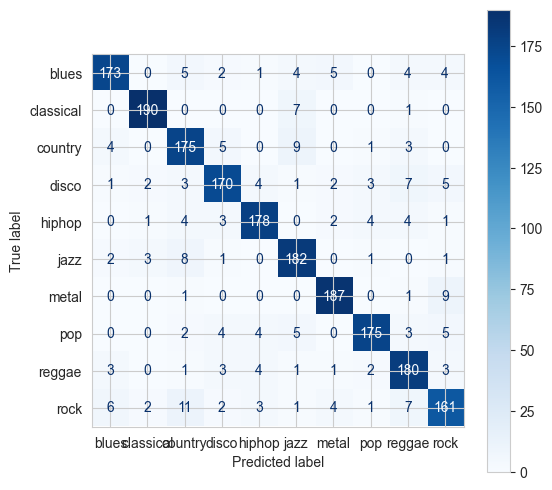

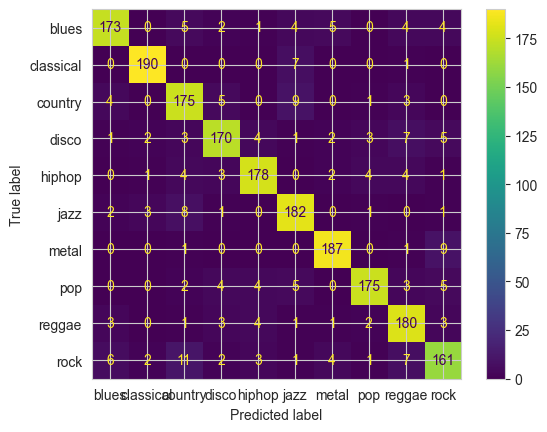

              precision    recall  f1-score   support

       blues      0.915     0.874     0.894       198
   classical      0.960     0.960     0.960       198
     country      0.833     0.888     0.860       197
       disco      0.895     0.859     0.876       198
      hiphop      0.918     0.904     0.910       197
        jazz      0.867     0.919     0.892       198
       metal      0.930     0.944     0.937       198
         pop      0.936     0.884     0.909       198
      reggae      0.857     0.909     0.882       198
        rock      0.852     0.813     0.832       198

    accuracy                          0.895      1978
   macro avg      0.896     0.895     0.895      1978
weighted avg      0.896     0.895     0.895      1978



In [70]:
predictProba(cbc, X_train_rfe,y_train, True)

Model Tuning

RF Model HP Tuning

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 15, 30, 45, 60],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [10, 140, 270, 400]}


In [72]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=12),
             n_jobs=-1,
             param_grid={'max_depth': [1, 15, 30, 45, 60],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 140, 270, 400]},
             scoring='f1_weighted', verbose=2)

In [73]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=400,
                       n_jobs=-1, random_state=12)


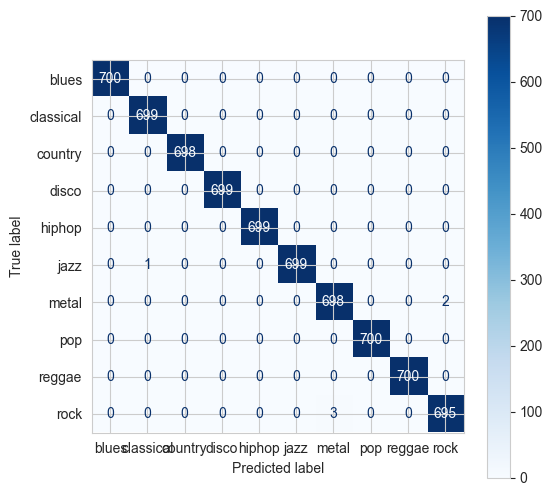

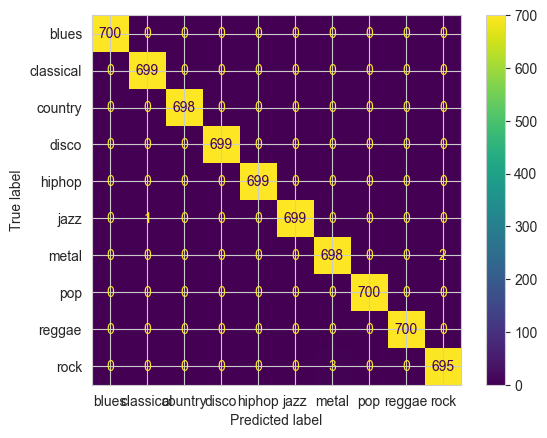

              precision    recall  f1-score   support

       blues      1.000     1.000     1.000       700
   classical      0.999     1.000     0.999       699
     country      1.000     1.000     1.000       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      1.000     0.999     0.999       700
       metal      0.996     0.997     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      1.000     1.000     1.000       700
        rock      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [75]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe, y_train)


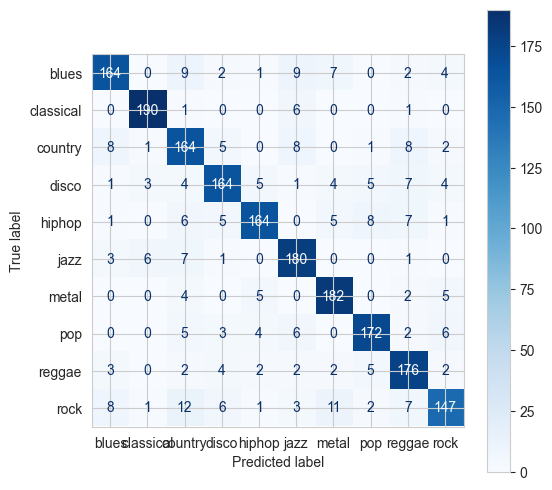

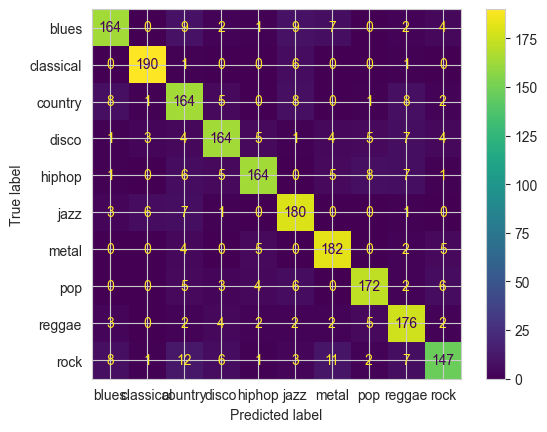

              precision    recall  f1-score   support

       blues      0.872     0.828     0.850       198
   classical      0.945     0.960     0.952       198
     country      0.766     0.832     0.798       197
       disco      0.863     0.828     0.845       198
      hiphop      0.901     0.832     0.865       197
        jazz      0.837     0.909     0.872       198
       metal      0.863     0.919     0.890       198
         pop      0.891     0.869     0.880       198
      reggae      0.826     0.889     0.856       198
        rock      0.860     0.742     0.797       198

    accuracy                          0.861      1978
   macro avg      0.863     0.861     0.861      1978
weighted avg      0.863     0.861     0.861      1978



In [76]:
predictProba(rf_random.best_estimator_, X_train_rfe, y_train, True)

Model Evaluation

In [80]:
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.837     0.853     0.845       102
   classical      0.898     0.960     0.928       101
     country      0.780     0.765     0.772       102
       disco      0.905     0.843     0.873       102
      hiphop      0.876     0.833     0.854       102
        jazz      0.841     0.882     0.861       102
       metal      0.900     0.971     0.934       102
         pop      0.903     0.912     0.907       102
      reggae      0.829     0.853     0.841       102
        rock      0.811     0.716     0.760       102

    accuracy                          0.859      1019
   macro avg      0.858     0.859     0.858      1019
weighted avg      0.858     0.859     0.858      1019

RF Test Accuracy - 85.8684985279686


In [81]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.867     0.892     0.879       102
   classical      0.926     0.990     0.957       101
     country      0.800     0.824     0.812       102
       disco      0.918     0.882     0.900       102
      hiphop      0.946     0.863     0.903       102
        jazz      0.891     0.882     0.887       102
       metal      0.961     0.971     0.966       102
         pop      0.942     0.951     0.946       102
      reggae      0.877     0.912     0.894       102
        rock      0.835     0.794     0.814       102

    accuracy                          0.896      1019
   macro avg      0.896     0.896     0.896      1019
weighted avg      0.896     0.896     0.896      1019

CatBoost Test Accuracy - 89.59764474975465
